# 随机梯度下降法
前面我们介绍了梯度下降法的数学原理，下面我们通过例子来说明一下随机梯度下降法，我们分别从 0 自己实现，以及使用 pytorch 中自带的优化器

In [1]:
!pip install torchvision

Looking in indexes: http://mirrors.cloud.aliyuncs.com/pypi/simple/
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255 # 将数据变到 0 ~ 1 之间
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

随机梯度下降法非常简单，公式就是
$$
\theta_{i+1} = \theta_i - \eta \nabla L(\theta)
$$
非常简单，我们可以从 0 开始自己实现

In [3]:
def sgd_update(parameters, lr):
    for param in parameters:
        param.data = param.data - lr * param.grad.data

我们可以将 batch size 先设置为 1，看看有什么效果

In [4]:
train_data = DataLoader(train_set, batch_size=1, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses1 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2) # 使用 0.01 的学习率
        # 记录误差
        train_loss += loss.data
        if idx % 30 == 0:
            losses1.append(loss.data)
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.342931
epoch: 1, Train Loss: 0.205267
epoch: 2, Train Loss: 0.178357
epoch: 3, Train Loss: 0.154335
epoch: 4, Train Loss: 0.145226
使用时间: 363.92373 s


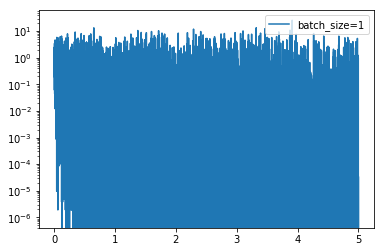

In [5]:
x_axis = np.linspace(0, 5, len(losses1), endpoint=True)
plt.semilogy(x_axis, losses1, label='batch_size=1')
plt.legend(loc='best')

可以看到，loss 在剧烈震荡，因为每次都是只对一个样本点做计算，每一层的梯度都具有很高的随机性，而且需要耗费了大量的时间

In [7]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses2 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2)
        # 记录误差
        train_loss += loss.data
        if idx % 30 == 0:
            losses2.append(loss.data)
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.739735
epoch: 1, Train Loss: 0.364468
epoch: 2, Train Loss: 0.318881
epoch: 3, Train Loss: 0.291949
epoch: 4, Train Loss: 0.270190
使用时间: 42.45408 s


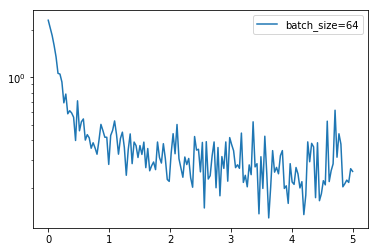

In [8]:
x_axis = np.linspace(0, 5, len(losses2), endpoint=True)
plt.semilogy(x_axis, losses2, label='batch_size=64')
plt.legend(loc='best')

通过上面的结果可以看到 loss 没有 batch 等于 1 震荡那么距离，同时也可以降到一定的程度了，时间上也比之前快了非常多，因为按照 batch 的数据量计算上更快，同时梯度对比于 batch size = 1 的情况也跟接近真实的梯度，所以 batch size 的值越大，梯度也就越稳定，而 batch size 越小，梯度具有越高的随机性，这里 batch size 为 64，可以看到 loss 仍然存在震荡，但这并没有关系，如果 batch size 太大，对于内存的需求就更高，同时也不利于网络跳出局部极小点，所以现在普遍使用基于 batch 的随机梯度下降法，而 batch 的多少基于实际情况进行考虑

下面我们调高学习率，看看有什么样的结果

In [10]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses3 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1) # 使用 1.0 的学习率
        # 记录误差
        train_loss += loss.data
        if idx % 30 == 0:
            losses3.append(loss.data)
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 2.393271
epoch: 1, Train Loss: 2.304841
epoch: 2, Train Loss: 2.304309
epoch: 3, Train Loss: 2.304929
epoch: 4, Train Loss: 2.305103
使用时间: 41.46898 s


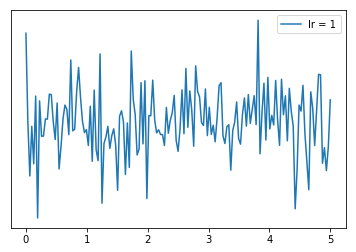

In [11]:
x_axis = np.linspace(0, 5, len(losses3), endpoint=True)
plt.semilogy(x_axis, losses3, label='lr = 1')
plt.legend(loc='best')

可以看到，学习率太大会使得损失函数不断回跳，从而无法让损失函数较好降低，所以我们一般都是用一个比较小的学习率

实际上我们并不用自己造轮子，因为 pytorch 中已经为我们内置了随机梯度下降发，而且之前我们一直在使用，下面我们来使用 pytorch 自带的优化器来实现随机梯度下降

In [13]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimzier = torch.optim.SGD(net.parameters(), 1e-2)
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimzier.zero_grad()
        loss.backward()
        optimzier.step()
        # 记录误差
        train_loss += loss.data
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.735391
epoch: 1, Train Loss: 0.365004
epoch: 2, Train Loss: 0.321273
epoch: 3, Train Loss: 0.294486
epoch: 4, Train Loss: 0.273154
使用时间: 38.12139 s


In [14]:
x_axis = np.linspace(0, 5, len(train_loss), endpoint=True)
plt.semilogy(x_axis, train_loss, label='lr = 1')
plt.legend(loc='best')

TypeError: len() of a 0-d tensor